# One China Principle: A Data Analysis
**Author:** Constance Chang\
**Date:** November 2025\
**Tools:** Python, Selenium, SQL, Jupyter Notebook
## Executive Summary
Recent reports highlight China's campaign promoting the "One China Principle"—a diplomatic position claiming Taiwan as part of China. While qualitative evidence is abundant, **this analysis constructs quantitative evidence** through 1,913 official documents scraped from China's Ministry of Foreign Affairs website.

### Key Findings
**Dramatic increase:** "One China Principle" mentions increased from 7 documents in 2015 to 44 documents in 2024\
**Positions shifted:** 43 countries shifted from "One China Policy" to "One China Principle" language

## Table of Contents
**Part 1: Data Preparation**
- [1.1 Loading Data](#11-loading-data)
- [1.2 Data Cleaning](#12-data-cleaning)
- [1.3 Creating SQL Database](#13-creating-sql-database)

**Part 2: Analysis**
- [2.1 Exploratory Analysis](#21-exploratory-analysis)
- [2.2 Key Findings](#22-key-findings)
- [2.3 Additional Patterns](#23-additional-patterns)

**Part 3: Conclusions**
- [Conclusions](#conclusions)

# Part 1: Data Preparation
This section covers data loading and database setup. If you want to skip to the analysis, [jump to Part 2](##exploratory-analysis).
## 1.1 Loading Data
The dataset contains **1,913 scraped documents** from the Chinese Ministry of Foreign Affairs website. Each document includes:
- Country name and region
- Publication year
- Binary indicators for "One China Policy" and "One China Principle" mentions
- Document title, text and URL

**Data source:** Scraped November 2025 using custom Python scraper ([`scraper.py`](https://github.com/constanceyushi/china-mfa-scraper/blob/main/scraper.py))\
**Translation:** Chinese text translated to English using Google Translate API([`translator.py`](https://github.com/constanceyushi/china-mfa-scraper/blob/main/translator.py))

In [1]:
# Import libraries
!pip install pandas
!pip install ipython-sql
import pandas as pd
import sqlite3
import prettytable
prettytable.DEFAULT = 'DEFAULT'
import matplotlib.pyplot as plt

# Load the translated dataset
df = pd.read_csv('EN_mfa_2025-11-26.csv')

# Display first few rows
df.head()

,region,country,title,year,text,policy,principle,link
0,ASIA,AFGHANISTAN,第四次中俄巴伊四国外长阿富汗问题非正式会议联合声明,2025,2025年9月25日，应俄罗斯联邦邀请，第四次中华人民共和国、俄罗斯联邦、巴基斯坦伊斯兰共和...,No,No,https://www.mfa.gov.cn/web/ziliao_674904/1179_...
1,ASIA,AFGHANISTAN,第五次中国—阿富汗—巴基斯坦外长对话联合声明,2023,2023年5月6日，中国国务委员兼外长秦刚、阿富汗代理外长穆塔基、巴基斯坦外长比拉瓦尔在伊斯...,No,No,https://www.mfa.gov.cn/web/ziliao_674904/1179_...
2,ASIA,AFGHANISTAN,第二次中俄巴伊四国外长阿富汗问题非正式会议联合声明,2023,2023年4月13日，中国、俄罗斯、巴基斯坦、伊朗四国外长在乌兹别克斯坦撒马尔罕举行第二次阿...,No,No,https://www.mfa.gov.cn/web/ziliao_674904/1179_...
3,ASIA,AFGHANISTAN,“阿富汗邻国+阿富汗”外长对话主席声明,2022,2022年3月31日，“阿富汗邻国＋阿富汗”外长对话在中国安徽屯溪举行。中国国务委员兼外长王...,No,No,https://www.mfa.gov.cn/web/ziliao_674904/1179_...
4,ASIA,AFGHANISTAN,阿富汗邻国关于支持阿富汗经济重建及务实合作的屯溪倡议,2022,2022年3月31日，第三次阿富汗邻国外长会在中国安徽屯溪举行。中国、伊朗、巴基斯坦、俄罗斯...,No,No,https://www.mfa.gov.cn/web/ziliao_674904/1179_...


## 1.2 Data Cleaning
Before analysis, I'll check for data quality issues and clean the dataset.
### Identifying Missing Values

In [2]:
# Inspect data structure and missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   region     1912 non-null   object 
 1   country    1912 non-null   object 
 2   title      1901 non-null   object 
 3   year       1901 non-null   float64
 4   text       1901 non-null   object 
 5   policy     1912 non-null   object 
 6   principle  1912 non-null   object 
 7   link       1912 non-null   object 
dtypes: float64(1), object(7)
memory usage: 119.6+ KB


region        0
country       0
title        11
year         11
text         11
policy        0
principle     0
link          0
dtype: int64

**Findings: 9 rows contain missing values in the `title` and `year` columns.**

Let's examine these rows more closely:

In [3]:
#Check null data
display(df[df['title'].isnull()])
display(df[df['year'].isnull()])
display(df[df['text'].isnull()])

,region,country,title,year,text,policy,principle,link
606,ASIA,INDIA,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
869,EUROPE,DENMARK,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
1352,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1357,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1362,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,http://www.un.org/Depts/los/convention_agreeme...
1440,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1443,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1444,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1445,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1449,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...


,region,country,title,year,text,policy,principle,link
606,ASIA,INDIA,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
869,EUROPE,DENMARK,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
1352,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1357,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1362,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,http://www.un.org/Depts/los/convention_agreeme...
1440,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1443,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1444,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1445,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1449,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...


,region,country,title,year,text,policy,principle,link
606,ASIA,INDIA,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
869,EUROPE,DENMARK,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gj_676...
1352,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1357,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1362,INTERNATIONAL AND REGIONAL ORGANIZATIONS,UNITED NATIONS,NaN,NaN,NaN,No,No,http://www.un.org/Depts/los/convention_agreeme...
1440,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1443,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1444,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1445,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...
1449,INTERNATIONAL AND REGIONAL ORGANIZATIONS,ASIA-EUROPE MEETING,NaN,NaN,NaN,No,No,https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqz...


In [10]:
#check the urls
pd.set_option('display.max_colwidth', None)
invalid_indices =[606, 869, 1352, 1357, 1362, 1440, 1443, 1444, 1445, 1449, 1450]
df.iloc[invalid_indices,7]

606     https://www.mfa.gov.cn/web/gjhdq_676201/gj_676203/yz_676205/1206_677220/1207_677232/201708/P020210830291626702434.pdf
869     https://www.mfa.gov.cn/web/gjhdq_676201/gj_676203/oz_678770/1206_679062/1207_679074/201705/P020210930402697834898.pdf
1352          https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqzz_681964/lhg_681966/zywj_681978/201202/P020210830177988355354.doc
1357         https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqzz_681964/lhg_681966/zywj_681978/202311/P020231122576916820970.docx
1362                                              http://www.un.org/Depts/los/convention_agreements/texts/unclos/unclos_c.pdf
1440          https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqzz_681964/lhg_682206/zywj_682242/200609/P020211001614411956989.doc
1443          https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqzz_681964/lhg_682206/zywj_682242/200607/P020211001614405124974.pdf
1444          https://www.mfa.gov.cn/web/gjhdq_676201/gjhdqzz_681964/lhg_682206/zywj_682242/200606/P020211001614401888

### Handling Missing Data

After inspecting the URLs of documents with missing data, I found the 11 documents are either pdf or doc files that the scraper failed to pick up. The 11 documents do not mention either the one China policy or principle, so I will drop them.

In [12]:
# Drop invalid documents
df = df.drop(invalid_indices)
df = df.reset_index(drop=True)

# Verify no missing values remain
df.isnull().sum()

region       0
country      0
title        0
year         0
text         0
policy       0
principle    0
link         0
dtype: int64

### Checking for Duplicates

In [15]:
df.duplicated().sum()

0

**Result:** No duplicate rows found.

### Data Type Corrections

The `year` column needs to be converted from float to string format:

In [18]:
# Check current data types
df.dtypes

# Convert year to string (remove .0)
df['year'] = df['year'].apply(lambda x: str(int(x)))

# Verify changes
pd.set_option('display.max_colwidth', 50)
df.dtypes

region       object
country      object
title        object
year         object
text         object
policy       object
principle    object
link         object
dtype: object

### Saving Cleaned Data

In [20]:
# Save cleaned dataset
df.to_csv('EN_mfa_2025-11-26.csv', index=False)

## 1.3 Creating SQL Database

To enable efficient SQL querying, I'll load the cleaned dataset into a SQLite database:

In [2]:
# Create SQLite database connection
con = sqlite3.connect("MFA.db")

# Configure SQL magic for Jupyter
%load_ext sql
%config SqlMagic.autopandas = True
%sql sqlite:///MFA.db

# Load cleaned data
df = pd.read_csv('EN_mfa_2025-11-26.csv')

# Import data into SQL table
df.to_sql("ONE_CHINA", con, if_exists='replace', index=False, method="multi")
con.close()

# Bilateral documents
%sql SELECT COUNT(*) as total_documents, COUNT(DISTINCT country) as countries FROM ONE_CHINA WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS';

 * sqlite:///MFA.db
Done.


,total_documents,countries
0,1345,172


In [3]:
#International platforms or organizations
%sql SELECT COUNT(*) as total_documents, COUNT(DISTINCT country) as international_org FROM ONE_CHINA WHERE region = 'INTERNATIONAL AND REGIONAL ORGANIZATIONS';

 * sqlite:///MFA.db
Done.


,total_documents,international_org
0,545,31


**Database ready:** 1,345 documents from 172 countries, and 545 documents from 31 international organizations loaded into `ONE_CHINA` table.

---

# Part 2: Analysis

## 2.1 Exploratory Analysis

### Research Question 1: How has mention of "One China Principle" changed over time?

To understand diplomatic trends, I'll first examine how frequently the "One China Principle" appears in bilateral documents between China and other countries over time.

 * sqlite:///MFA.db
Done.


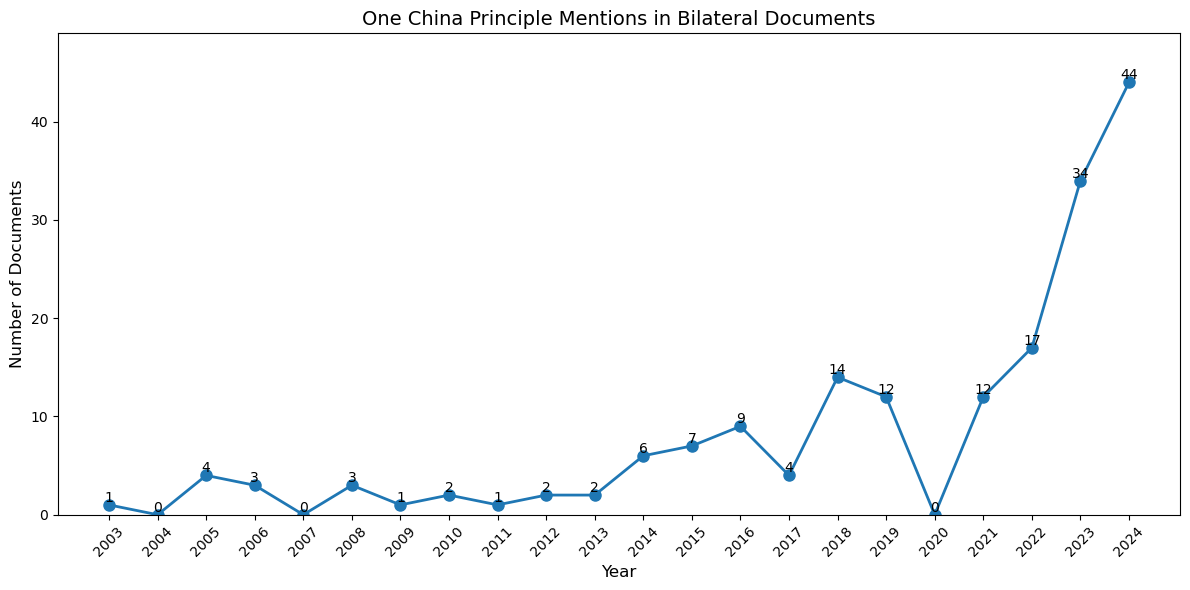

In [44]:
# Query: Count principle mentions by year (excluding international orgs and incomplete 2025 data)
principletrend = %sql SELECT year, COUNT(principle) as count_principle \
                      FROM ONE_CHINA \
                      WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS' \
                      AND principle='Yes' \
                      AND year != 2025 \
                      GROUP BY year \
                      ORDER BY year

# Convert year to integer for continuous axis
principletrend['year'] = principletrend['year'].astype(int)

# Create complete year range
min_year = principletrend['year'].min()
max_year = principletrend['year'].max()
all_years = pd.DataFrame({'year': range(min_year, max_year + 1)})

# Merge and fill missing years
df_complete = all_years.merge(principletrend, on='year', how='left')
df_complete['count_principle'] = df_complete['count_principle'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_complete['year'], df_complete['count_principle'], 
        marker='o', linewidth=2, markersize=8)

# Add data labels
for idx, row in df_complete.iterrows():
    ax.text(row['year'], row['count_principle'], 
            str(int(row['count_principle'])),
            ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Documents', fontsize=12)
ax.set_title('One China Principle Mentions in Bilateral Documents', fontsize=14)
ax.set_ylim(0, 49)
ax.set_xticks(df_complete['year'])  # Show all years
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Key Observation:** 
- Mentions increased from **1 in 2003** to **44 in 2024**
- Overall trend shows a sharp increase since 2018

The data supports the observation that there is growing emphasis on the one China pinciple in diplomatic communications by China.

---

### Research Question 2: How does "One China Policy" compare?

Now let's examine mentions of "One China Policy" to compare the two terminologies:

 * sqlite:///MFA.db
Done.


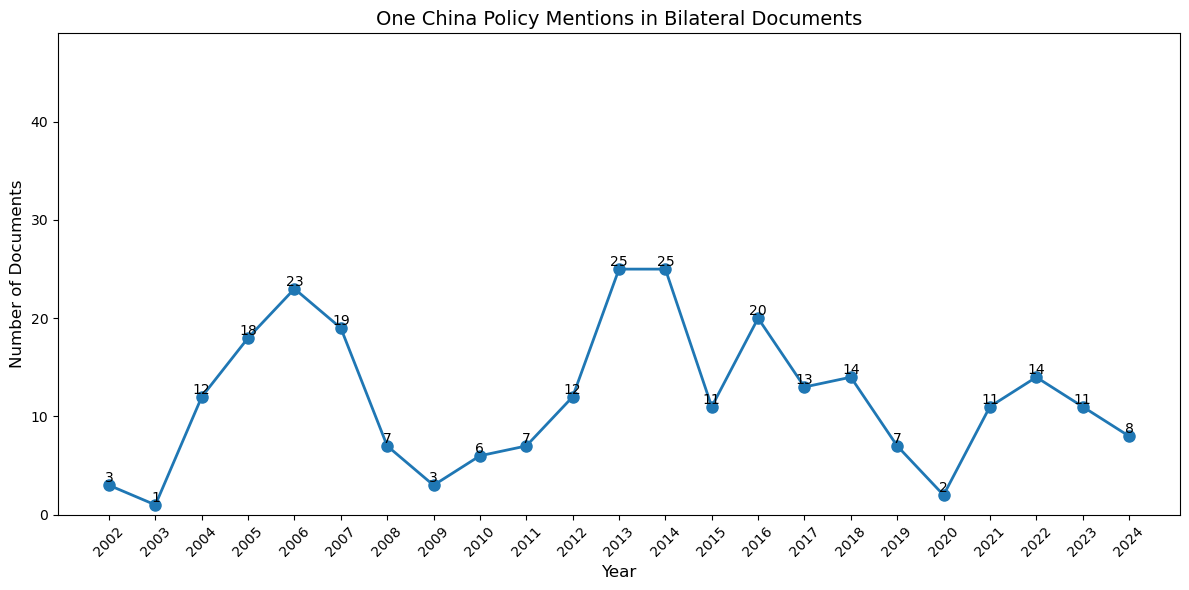

In [39]:
# Query: Count policy mentions by year
policytrend = %sql SELECT year, COUNT(policy) as count_policy \
                   FROM ONE_CHINA \
                   WHERE region != 'international and regional organizations' \
                   AND policy='Yes' \
                   AND year != 2025 \
                   GROUP BY year \
                   ORDER BY year
# Convert year to integer for continuous axis
policytrend['year'] = policytrend['year'].astype(int)
# Create complete year range
min_year = policytrend['year'].min()
max_year = policytrend['year'].max()
all_years = pd.DataFrame({'year': range(min_year, max_year + 1)})
# Merge and fill missing years
policy_complete = all_years.merge(policytrend, on='year', how='left')
policy_complete['count_policy'] = policy_complete['count_policy'].fillna(0)
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(policy_complete['year'], policy_complete['count_policy'], 
        marker='o', linewidth=2, markersize=8)
# Add data labels
for idx, row in policy_complete.iterrows():
    ax.text(row['year'], row['count_policy'], 
            str(int(row['count_policy'])),
            ha='center', va='bottom', fontsize=10)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Documents', fontsize=12)
ax.set_title('One China Policy Mentions in Bilateral Documents', fontsize=14)
ax.set_ylim(0, 49)
ax.set_xticks(policy_complete['year'])  # Show all years
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Key Observation:**
- Policy mentions show an overall downward trend
- The mention of policy peaked around 2013-2014, and decresed since then.

---

### Comparing Both Trends Side-by-Side

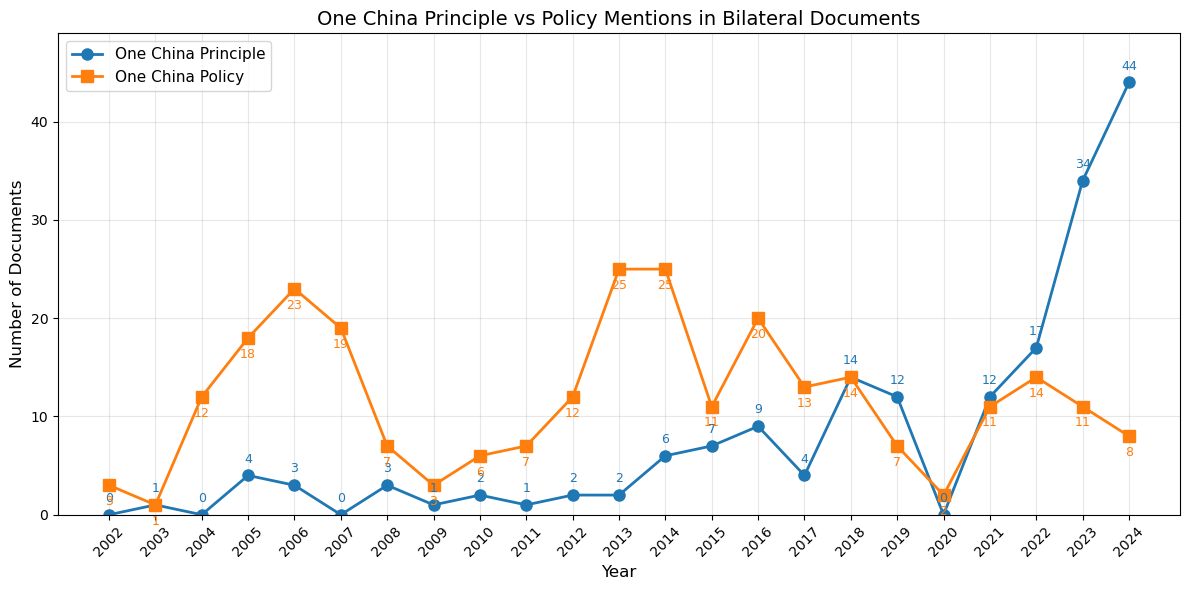

In [49]:
# Merge both datasets on year
combined = df_complete.merge(
    policy_complete, 
    on='year', 
    how='outer'
).fillna(0)

# Sort by year to ensure proper plotting
combined = combined.sort_values('year')

# Create the combined plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot both lines
ax.plot(combined['year'], combined['count_principle'], 
        marker='o', linewidth=2, markersize=8, label='One China Principle', color='#1f77b4')
ax.plot(combined['year'], combined['count_policy'], 
        marker='s', linewidth=2, markersize=8, label='One China Policy', color='#ff7f0e')

# Add data labels for both lines
for idx, row in combined.iterrows():
    # Principle labels
    ax.text(row['year'], row['count_principle'] +1, 
            str(int(row['count_principle'])),
            ha='center', va='bottom', fontsize=9, color='#1f77b4')
    # Policy labels (offset slightly to avoid overlap)
    ax.text(row['year'], row['count_policy'] -1, 
            str(int(row['count_policy'])),
            ha='center', va='top', fontsize=9, color='#ff7f0e')

# Formatting
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Documents', fontsize=12)
ax.set_title('One China Principle vs Policy Mentions in Bilateral Documents', fontsize=14)
ax.set_ylim(0, 49)
ax.set_xticks(combined['year'])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Finding:** The campaign to promote one China principle became visible around 2021 when the mention of principle surpassed policy. 

---

### Research Question 3: How do international organizations differ?

International organizations may have different patterns than individual countries. Let's examine them separately:

 * sqlite:///MFA.db
Done.


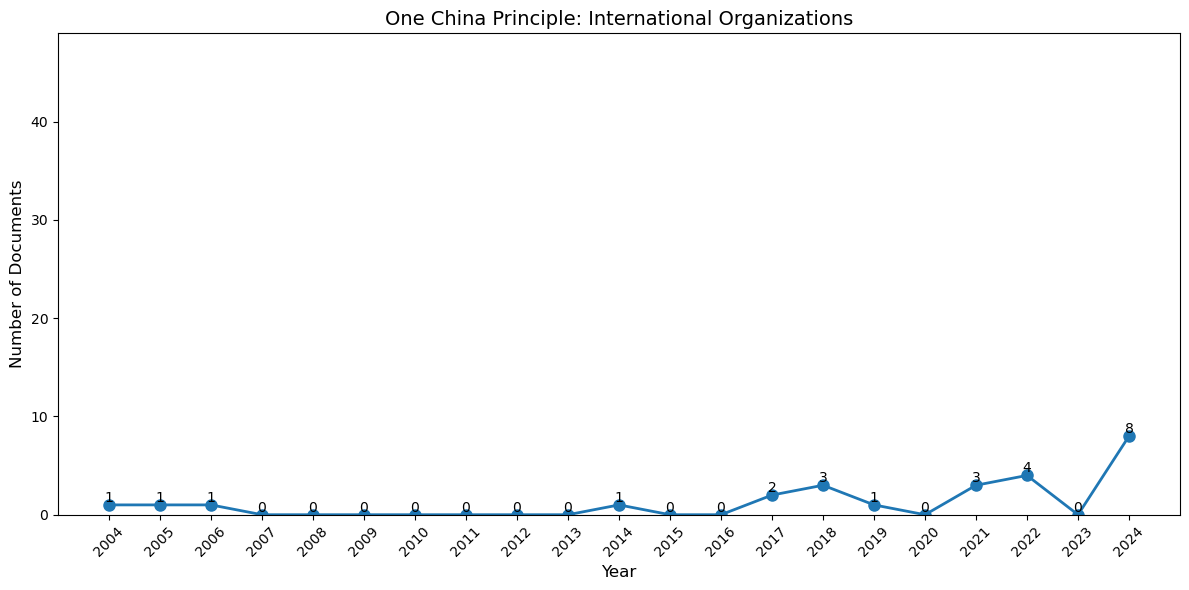

In [52]:
# Query: Principle mentions by international organizations
intorg_principle = %sql SELECT year, COUNT(principle) as count_principle \
                        FROM ONE_CHINA \
                        WHERE region = 'INTERNATIONAL AND REGIONAL ORGANIZATIONS' \
                        AND principle='Yes' \
                        AND year != 2025 \
                        GROUP BY year \
                        ORDER BY year

# Convert year to integer for continuous axis
intorg_principle['year'] = intorg_principle['year'].astype(int)
# Create complete year range
min_year = intorg_principle['year'].min()
max_year = intorg_principle['year'].max()
all_years = pd.DataFrame({'year': range(min_year, max_year + 1)})
# Merge and fill missing years
int_complete = all_years.merge(intorg_principle, on='year', how='left')
int_complete['count_principle'] = int_complete['count_principle'].fillna(0)
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(int_complete['year'], int_complete['count_principle'], 
        marker='o', linewidth=2, markersize=8)
# Add data labels
for idx, row in int_complete.iterrows():
    ax.text(row['year'], row['count_principle'], 
            str(int(row['count_principle'])),
            ha='center', va='bottom', fontsize=10)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Documents', fontsize=12)
ax.set_title('One China Principle: International Organizations', fontsize=14)
ax.set_ylim(0, 49)
ax.set_xticks(int_complete['year'])  # Show all years
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

**Key Observation:**
- There is also an increase of principle in documents of nternational organizations.
- But the numbers seems quite small, so I will not examine further.

---

### Summary of Exploratory Findings

Based on the trend analysis:

1. **Principle mentions**: increase
2. **Policy mentions**: decrease
3. **International organizations**:increasing mention of principle

**Next question:** Which specific countries have shifted from "Policy" to "Principle" language? [Continue to next section](#22-identifying-country-shifts)

---

## 2.2 Key Findings

### Finding 1: Identifying Countries That Shifted to "Principle" Language

**Research Question:** Which countries have shifted from using "One China Policy" to "One China Principle" in their most recent documents with China?

**Methodology:** I identify countries where:
1. Their most recent document mentions "One China Principle"
2. This occurred AFTER they previously mentioned "One China Policy"
3. This suggests a shift in diplomatic language alignment
4. **Countries that have always supported "One China Principle" are not counted**

In [6]:
# Create table of countries that shifted from Policy to Principle
query = """
DROP TABLE IF EXISTS Changed_Countries;
CREATE TABLE Changed_Countries AS
SELECT region, country,
       MAX(CASE WHEN policy = 'Yes' THEN year ELSE 0 END) as latest_policy_year,
       MAX(CASE WHEN principle = 'Yes' THEN year ELSE 0 END) as latest_principle_year
FROM ONE_CHINA
WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS'
GROUP BY region, country
HAVING MAX(CASE WHEN policy = 'Yes' THEN year ELSE 0 END) != 0
   AND MAX(CASE WHEN policy = 'Yes' THEN year ELSE 0 END) < MAX(CASE WHEN principle = 'Yes' THEN year ELSE 0 END)
ORDER BY region
"""

%sql {query}

# Display the shifted countries
%sql SELECT * FROM Changed_Countries ORDER BY latest_principle_year DESC 

 * sqlite:///MFA.db
Done.
Done.
 * sqlite:///MFA.db
Done.


,region,country,latest_policy_year,latest_principle_year
0,AFRICA,ANGOLA,2006,2025
1,AFRICA,KENYA,2014,2025
2,ASIA,ARMENIA,2015,2025
3,ASIA,CAMBODIA,2021,2025
4,ASIA,KAZAKHSTAN,2022,2025
5,ASIA,KYRGYZSTAN,2022,2025
6,ASIA,PAKISTAN,2023,2025
7,ASIA,SRI LANKA,2016,2025
8,ASIA,TURKMENISTAN,2022,2025
9,ASIA,UZBEKISTAN,2022,2025


In [10]:
#group by year
%sql SELECT latest_principle_year, COUNT(*) FROM Changed_Countries GROUP BY latest_principle_year

 * sqlite:///MFA.db
Done.


,latest_principle_year,COUNT(*)
0,2008,1
1,2016,1
2,2017,1
3,2018,2
4,2019,4
5,2022,5
6,2023,8
7,2024,10
8,2025,11


Finding: **43 countries** have shifted from "Policy" to "Principle" language in their bilateral documents with China, with most changes occured in **2024 and 2025**.

Sample countries: Angola, Cambodia, UAE and Serbia.

---

### Finding 2: Regional Distribution of Language Shifts

Which regions have the most countries adopting "Principle" language?

In [11]:
# Count shifts by region
regional_summary = %sql SELECT region, COUNT(*) as number_of_countries \
                        FROM Changed_Countries \
                        GROUP BY region \
                        ORDER BY number_of_countries DESC

# Display table
regional_summary

 * sqlite:///MFA.db
Done.


,region,number_of_countries
0,ASIA,19
1,EUROPE,9
2,AFRICA,9
3,SOUTH AMERICA,5
4,OCEANIA,1


 * sqlite:///MFA.db
Done.


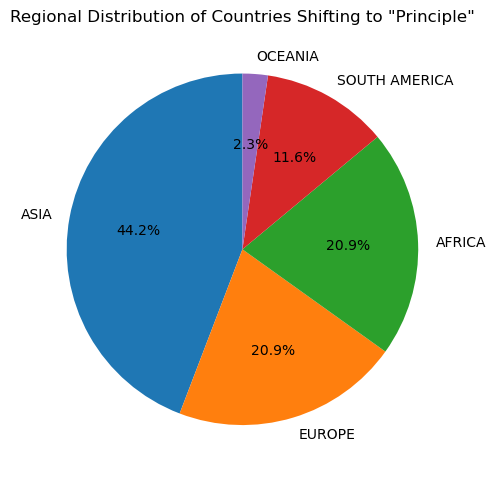

In [12]:
# Visualize regional distribution
regionchanged = %sql SELECT region, COUNT(*) as number_of_countries \
                     FROM Changed_Countries \
                     GROUP BY region \
                     ORDER BY number_of_countries DESC

fig, ax = plt.subplots(figsize=(5, 5))
regionchanged.plot(kind='pie', y='number_of_countries', 
                   labels=regionchanged['region'],
                   autopct='%1.1f%%', 
                   title='Regional Distribution of Countries Shifting to "Principle"',
                   ax=ax, legend=False, startangle=90)
plt.ylabel('')
plt.tight_layout()
plt.show()

**Key Insights:**
- **Asia** accounts for **44%** of countries that shifted (19 countries)
- **Africa** represents **21%** (9 countries)
- **Europe** comprises **21%** (9 countries)

---

---

### Finding 3: Countries Maintaining "Policy" Language

For comparison, let's examine countries whose most recent mention is still "Policy" rather than "Principle":

In [15]:
# Create table of countries still using Policy language
query = """
DROP TABLE IF EXISTS Same_Countries;

CREATE TABLE Same_Countries AS
SELECT region, country,
       MAX(CASE WHEN policy = 'Yes' THEN year ELSE 0 END) as latest_policy_year,
       MAX(CASE WHEN principle = 'Yes' THEN year ELSE 0 END) as latest_principle_year
FROM ONE_CHINA
WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS'
GROUP BY region, country
HAVING latest_policy_year > latest_principle_year
ORDER BY region
"""

%sql {query}

%sql SELECT * FROM Same_Countries

 * sqlite:///MFA.db
Done.
Done.
 * sqlite:///MFA.db
Done.


,region,country,latest_policy_year,latest_principle_year
0,AFRICA,CAMEROON,2007,0
1,AFRICA,DJIBOUTI,2003,0
2,AFRICA,GHANA,2006,0
3,AFRICA,NAMIBIA,2007,0
4,AFRICA,SOUTH AFRICA,2024,0
5,AFRICA,SUDAN,2015,0
6,AFRICA,UGANDA,2006,0
7,ASIA,AFGHANISTAN,2016,0
8,ASIA,BRUNEI,2025,0
9,ASIA,INDONESIA,2023,0


In [18]:
# Count and display
same_result = %sql SELECT COUNT(*) as total FROM Same_Countries
policy_by_region = %sql SELECT region, COUNT(*) as count FROM Same_Countries GROUP BY region ORDER BY count DESC

policy_by_region

 * sqlite:///MFA.db
Done.
 * sqlite:///MFA.db
Done.


,region,count
0,EUROPE,15
1,ASIA,12
2,AFRICA,7
3,OCEANIA,3
4,SOUTH AMERICA,1
5,NORTH AMERICA,1


 * sqlite:///MFA.db
Done.


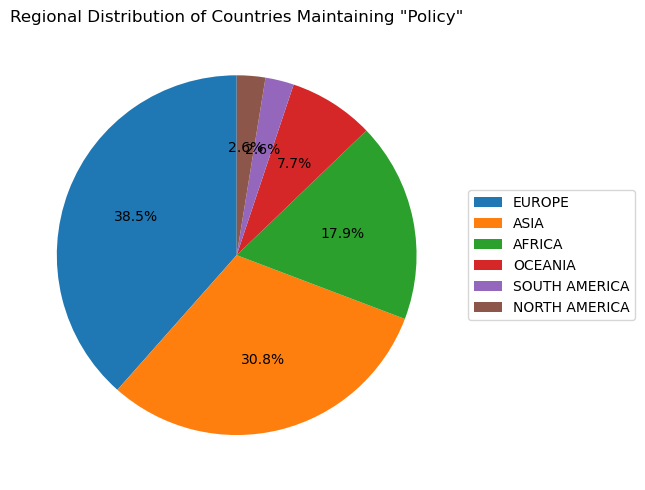

In [31]:
# Visualize regional distribution
policyregion = %sql SELECT region, COUNT(*) as number_of_countries \
                     FROM Same_Countries \
                     GROUP BY region \
                     ORDER BY number_of_countries DESC

fig, ax = plt.subplots(figsize=(7, 5))
policyregion.plot(kind='pie', y='number_of_countries',
                  labels=None,
                   autopct='%1.1f%%', 
                   title='Regional Distribution of Countries Maintaining "Policy"',
                   ax=ax, legend=True, startangle=90)
ax.legend(labels=policyregion['region'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('')
plt.tight_layout()
plt.show()

**Finding:** **39 countries** continue to use "One China Policy" as their most recent diplomatic language.
**Sample countries:** France, Slovakia, The Phillipines.

**Regional breakdown:**
- Europe: 15 countries
- Asia: 12 countries
---

### Summary of Key Findings

1. ✅ **43 countries** (25% of countries in dataset) have shifted to "Principle" language
2. ✅ **Asia and Africa** dominate shifts (56% combined), reflecting China's regional priorities
3. ✅ **39 countries** (23% of countries in dataset) maintain "Policy" language

---

## 2.3 Additional Patterns Worth Exploring

The dataset reveals other interesting diplomatic patterns that merit further investigation:

### Pattern 1: Strategic Partnership Agreements

How prevalent are strategic partnership agreements between China and other countries?

In [51]:
# Identify countries with strategic partnership agreements
# Note: Original Chinese text '战略' (strategic) and '伙伴' (partner)
# Trend analysis
query = """
DROP TABLE IF EXISTS Strategic_Countries;
CREATE TABLE Strategic_Countries AS
SELECT year, country
FROM ONE_CHINA
WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS'
AND title LIKE '%战略%'
AND title LIKE '%伙伴%'
"""

%sql {query}
%sql SELECT DISTINCT country FROM Strategic_Countries

 * sqlite:///MFA.db
Done.
Done.
 * sqlite:///MFA.db
Done.


,country
0,AFGHANISTAN
1,UNITED ARAB EMIRATES
2,OMAN
3,AZERBAIJAN
4,PAKISTAN
...,...
77,COLOMBIA
78,VENEZUELA
79,URUGUAY
80,CHILE


In [ ]:
**Observation:** **82 countries** have documents mentioning strategic partnerships with China.

#### Trend of Strategic Partnership Documents

 * sqlite:///MFA.db
Done.


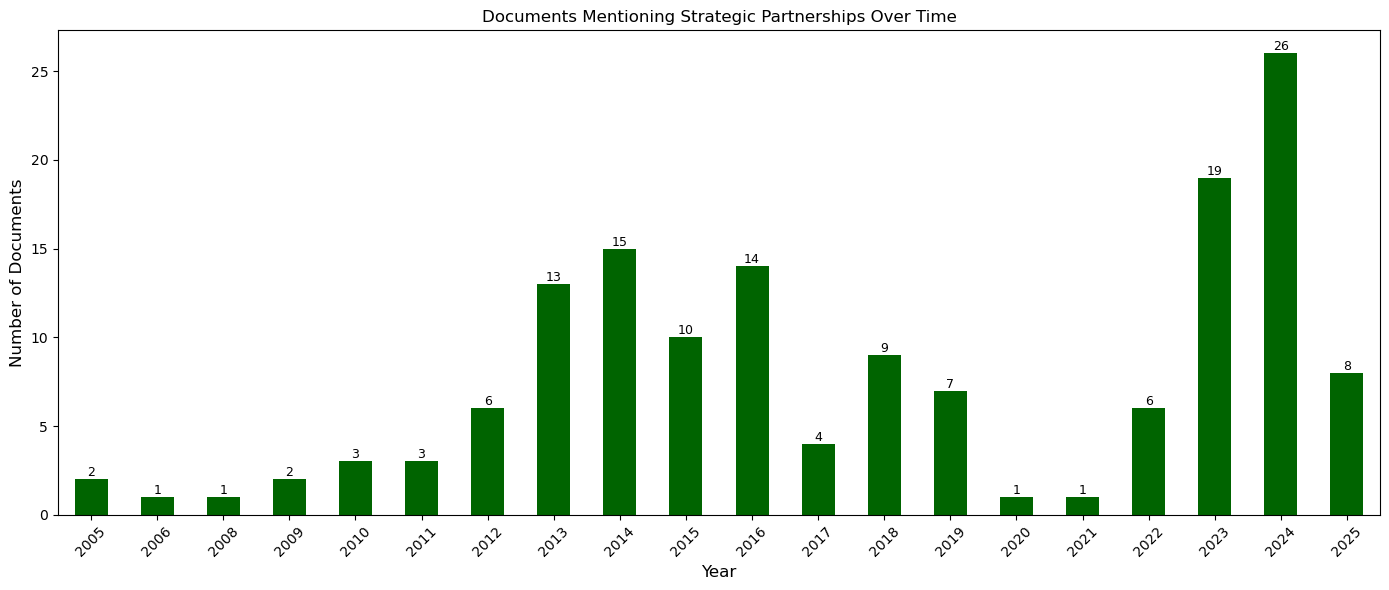

In [52]:
# Visualize
strategic_trend = %sql SELECT year, COUNT(*) as documents FROM Strategic_Countries GROUP BY year

ax = strategic_trend.plot(kind='bar', x='year', y='documents', 
                          figsize=(14, 6),
                          title='Documents Mentioning Strategic Partnerships Over Time',
                          legend=False, color='darkgreen')

# Add data labels
for i, row in strategic_trend.iterrows():
    ax.text(i, row['documents'], 
            str(row['documents']),
            ha='center', va='bottom', fontsize=9)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Pattern:** Strategic partnership mentions show an increasing trend, with a peak in 2024

---

### Pattern 2: UN Resolution 2758 References

China claims that UN Resolution 2758 (1971) recognizes Taiwan as part of China. There has been increasing effort by China to insert this language in diplomatic settings. What trend does the MFA documents show?

 * sqlite:///MFA.db
Done.
Total documents mentioning Resolution 2758: 10


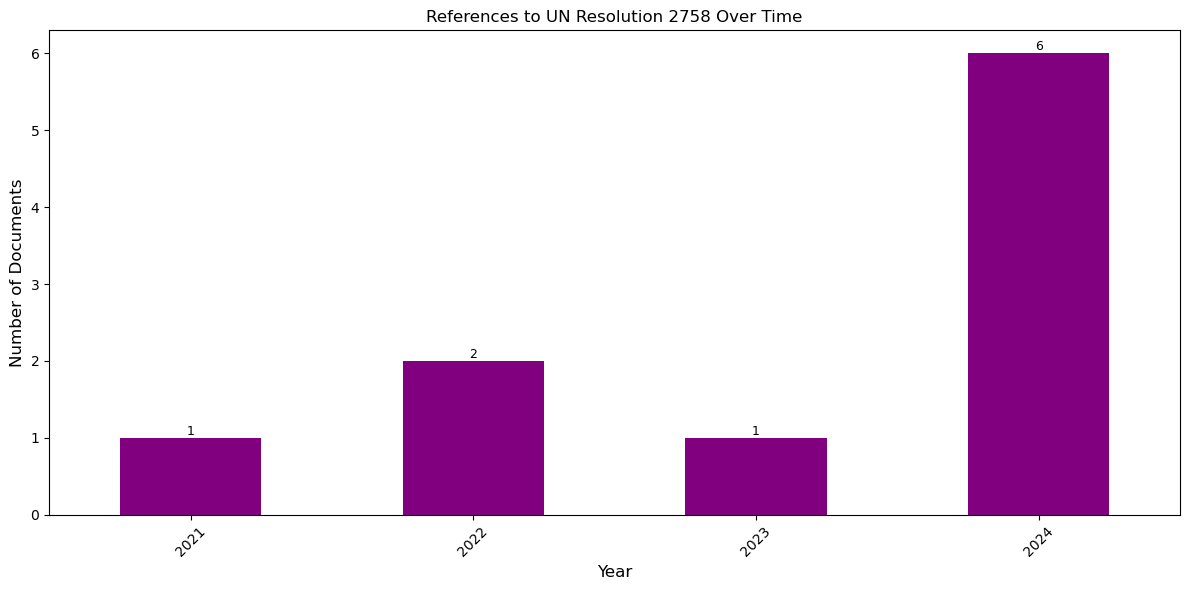

In [54]:
# Search for Resolution 2758 mentions
reso2758 = %sql SELECT year, COUNT(*) as documents \
                FROM ONE_CHINA \
                WHERE region != 'INTERNATIONAL AND REGIONAL ORGANIZATIONS' \
                AND (text LIKE '%2758%' AND text LIKE '%决议%') \
                AND year != 2025 \
                GROUP BY year \
                ORDER BY year

print(f"Total documents mentioning Resolution 2758: {reso2758['documents'].sum()}")

# Visualize
if len(reso2758) > 0:
    ax = reso2758.plot(kind='bar', x='year', y='documents',
                       figsize=(12, 6),
                       title='References to UN Resolution 2758 Over Time',
                       legend=False, color='purple')
    
    for i, row in reso2758.iterrows():
        ax.text(i, row['documents'], 
                str(row['documents']),
                ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Note: Resolution 2758 references are rare in bilateral documents")

**Pattern:** Resolution 2758 is mentioned in 10 documents, between 2021-2024.

**Interpretation:** This suggest the capaign to promote Resolution 2758 is a more recent trend.

---

# Part 3: Conclusions

The dataset presents quantitative evidence of China’s campaign to reshape international norms and justify its claims over Taiwan. The analysis finds strong evidence of China’s efforts to insert the “One China Principle” into diplomatic documents. Mentions of the One China Principle began rising in the mid-2010s and reached their highest recorded level in 2024. Around 43 countries are estimated to have shifted from the “One China Policy” to the “One China Principle,” with most changes occurring in 2025. The dataset also detects a recent trend of referencing UN Resolution 2758 in bilateral documents, beginning in 2021.